# Observations:
SigNet seems to do better than ReluNet with small noises

SigNet seems to train much faster with SGD than with Adam. Might just be because this is such a simple problem

In [1]:
%run base.ipynb
%matplotlib inline
import adabound
import candle
import functools as ft
import ignite.engine as engine
import matplotlib.pyplot as plt
import numpy as np
import siglayer
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torchdata

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

## Hyperparameters

In [2]:
noise = 0.1

path_channels = 3
path_length = 3
sig_depth = 2

max_epochs = 1000
display = True
display_every = 100

Optimizer = ft.partial(adabound.AdaBound, lr=0.01)
Loss = nn.MSELoss

## Data

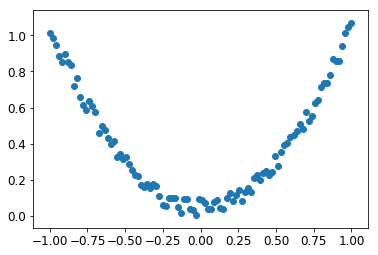

In [3]:
x = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1)  
y = x.pow(2) + noise * torch.rand(x.shape)             

plt.scatter(x.numpy(), y.numpy())
plt.show()

class ParabolaData(torchdata.Dataset):
    def __len__(self):
        return len(x)
    
    def __getitem__(self, item):
        return x[item], y[item]
    
dataloader = torchdata.DataLoader(ParabolaData(), batch_size=len(x))

In [4]:
assert len(x.shape) == 2
assert len(y.shape) == 2
output_size = y.size(1)

## Networks: SigNet and ReluNet

In [5]:
SigNet = candle.CannedNet.spec((path_channels * path_length,
                                siglayer.ReshapeSigLayer(path_channels, path_length, sig_depth),
                                output_size))

ReluNet = candle.CannedNet.spec((path_channels * path_length,
                                 F.relu,
                                 output_size))

## Train Model

In [6]:
def train_model(model, name, result_dict):
    model(x)  # Initialise all layers in model before passing parameters to optimizer
    optimizer = Optimizer(model.parameters())
    criterion = Loss()
    
    result_dict[name] = []
    
    trainer = candle.create_supervised_trainer(model, optimizer, criterion, 
                                               check_nan=True, grad_clip=1.0, output_predictions=True)

    @trainer.on(engine.Events.EPOCH_COMPLETED)
    def callback(trainer):
        loss, predictions = trainer.state.output
        assert len(predictions) == len(x)
        result_dict[name].append(loss)
        
        if display and trainer.state.epoch % display_every == 0:
            plt.scatter(x.numpy(), y.numpy())
            plt.plot(x.numpy(), predictions.detach().numpy(), 'r-', lw=5)
            plt.text(1.2, 0.25, f'Epoch={trainer.state.epoch}', fontdict={'size': 20, 'color':  'red'})
            plt.text(1.2, 0, f'Loss={loss}', fontdict={'size': 20, 'color':  'red'})
            plt.show()

    trainer.run(dataloader, max_epochs=max_epochs)

In [7]:
result_dict = {}

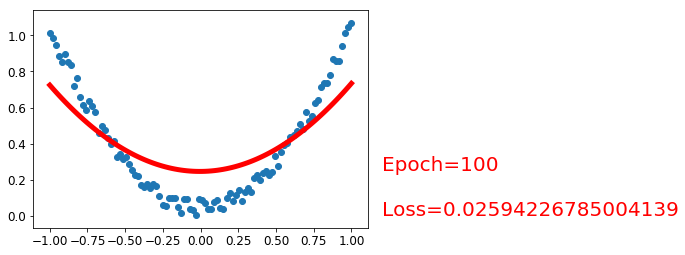

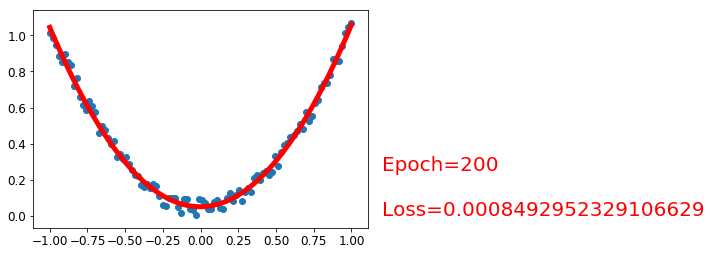

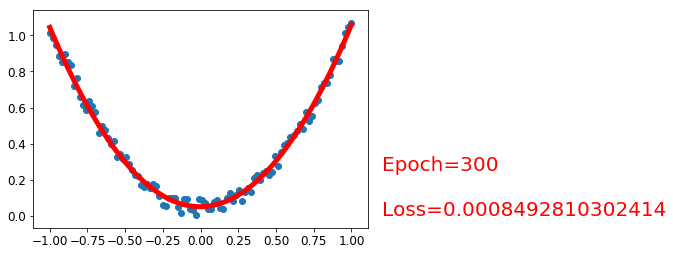

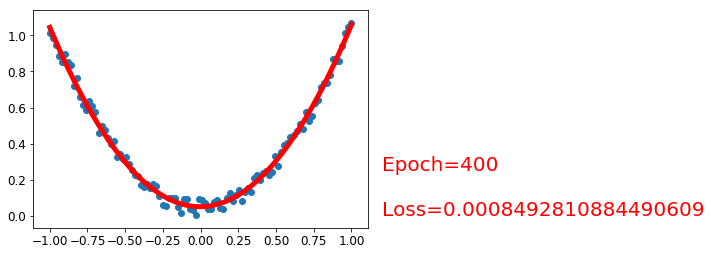

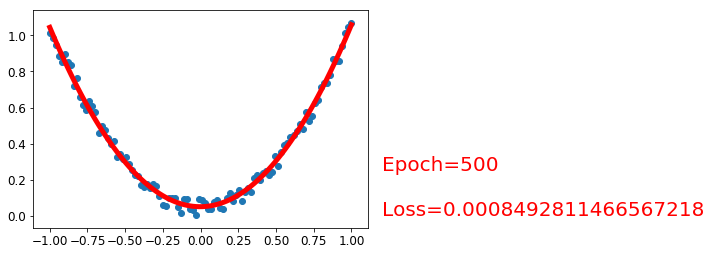

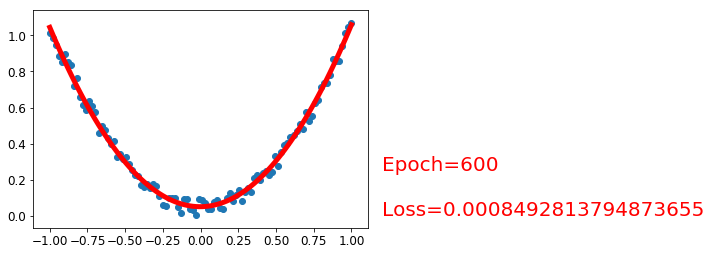

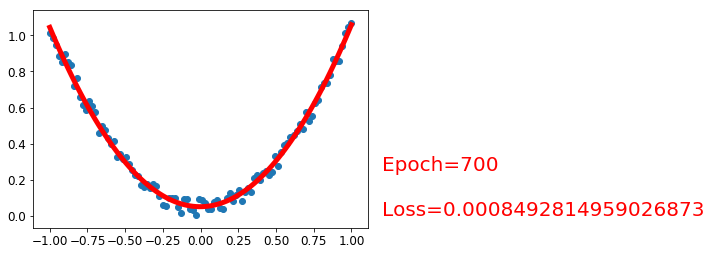

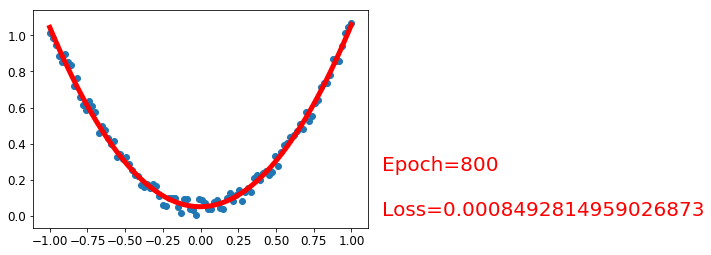

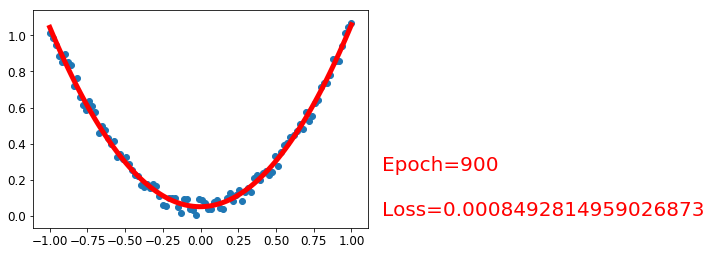

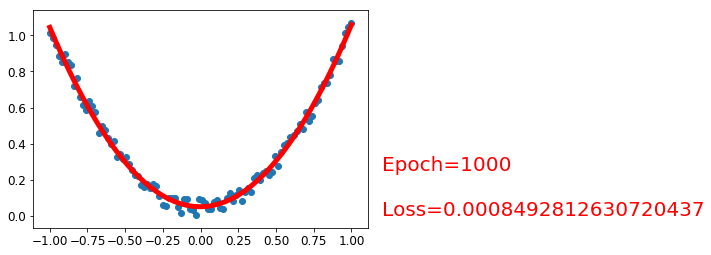

In [8]:
signet = SigNet()
train_model(signet, 'SigNet', result_dict)

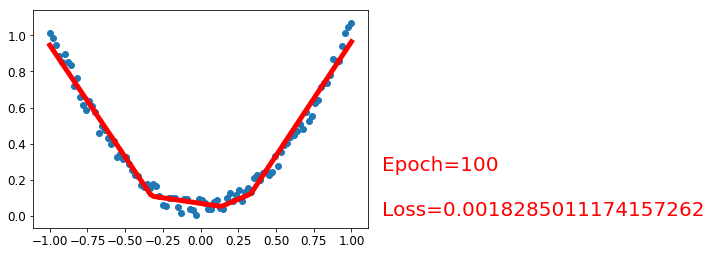

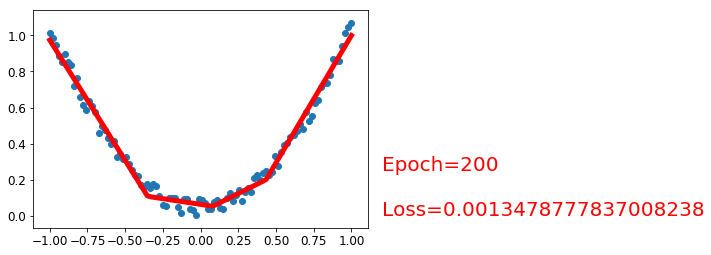

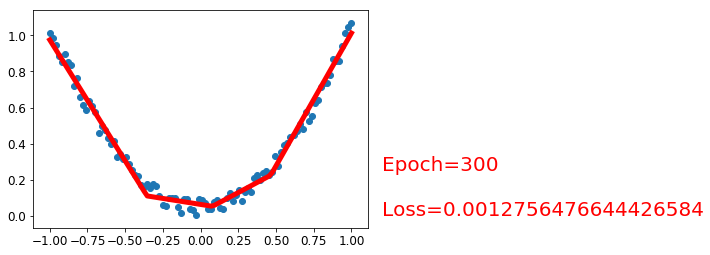

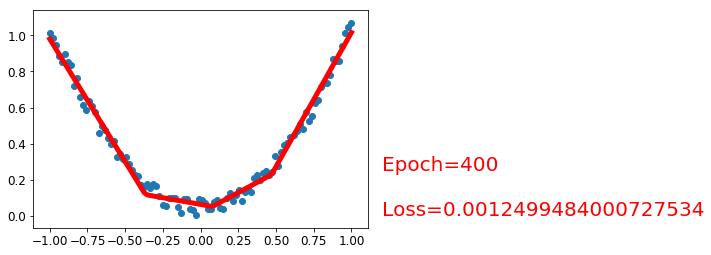

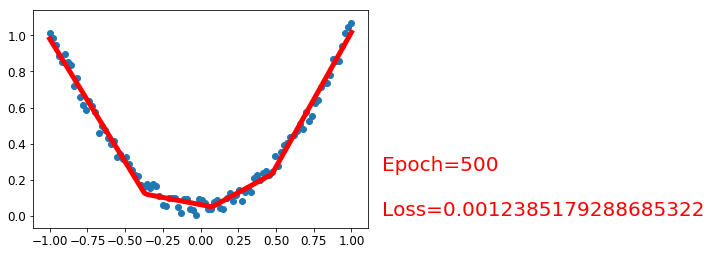

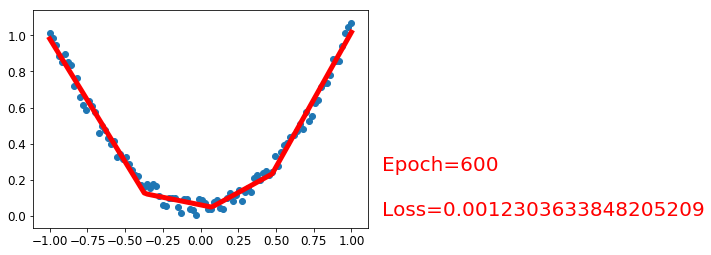

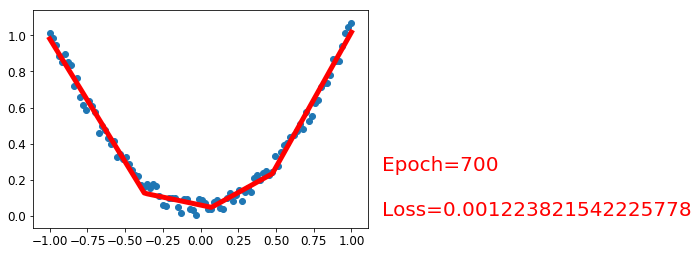

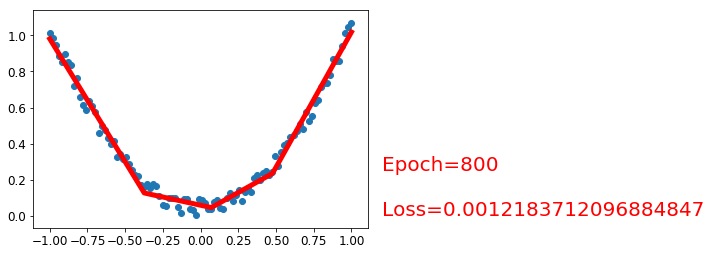

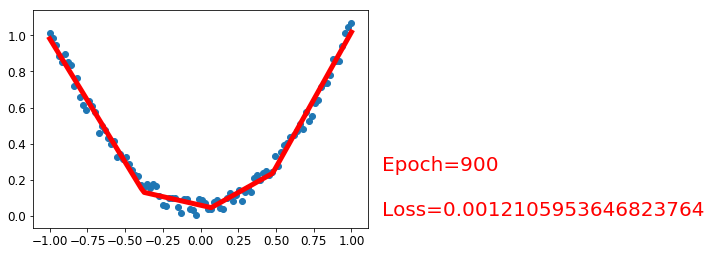

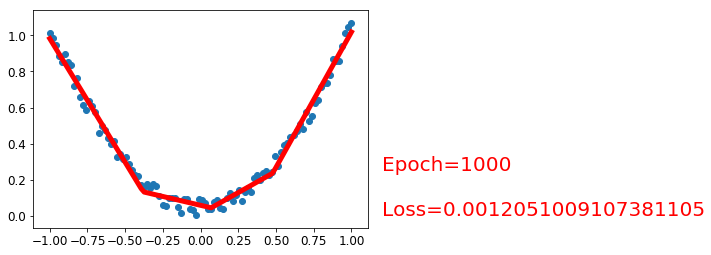

In [9]:
relunet = ReluNet()
train_model(relunet, 'ReluNet', result_dict)

## Results

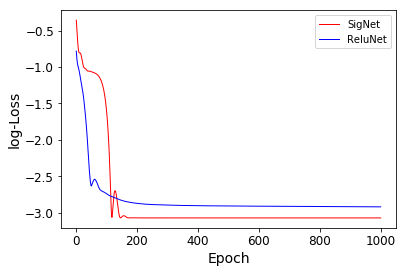

SigNet parameter count: 31
ReluNet parameter count: 28


In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

plt.plot(range(1, max_epochs + 1), np.log10(result_dict['SigNet']), 'r-', lw=1, label='SigNet')
plt.plot(range(1, max_epochs + 1), np.log10(result_dict['ReluNet']), 'b-', lw=1, label='ReluNet')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('log-Loss')
plt.show()

print(f'SigNet parameter count: {count_parameters(signet)}')
print(f'ReluNet parameter count: {count_parameters(relunet)}')